### Classificando textos com machine learning

Este notebook contem a classificação de reclamações do site Reclame aqui utilizando modelos de machine learning. 
Algoritmo utilizado:

* SVM com estimador SGDClassifier


### Dataset

O dataset possuí texto da reclamação e sua respectiva avaliação.

### Importações

In [40]:
import sys

import pandas as pd
import numpy as np
from unidecode import unidecode

import nltk
from nltk.corpus import stopwords

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Numpy: {}'.format(np.__version__))


Python: 3.11.6 (main, Oct  3 2023, 00:00:00) [GCC 13.2.1 20230728 (Red Hat 13.2.1-1)]
NLTK: 3.8.1
Scikit-learn: 1.2.0
Pandas: 1.5.2
Numpy: 1.24.3


### Funçẽos e operações globais

In [41]:
#Operações globais
import warnings
warnings.simplefilter("ignore")

stop_words = set(stopwords.words('portuguese'))
nltk.download('rslp')


##Funções
def concat_filter(row):
    
    if pd.notnull(row['title']) and pd.notnull(row['description']):
        return f"{row['title']}. {row['description']}"
    
    if pd.notnull(row['title']):
        return f"{row['title']}"
    
    if pd.notnull(row['description']):
        return f"{row['description']}"
    
    return None


def replace_words(text_messages):
    # Substituindo e-mails, urls númeoros de telefone, outros números e esprços

    # Substituindo por 'emailaddress'
    processed = text_messages.str.replace(r'^.+@[^\.].*\.[a-z]{2,}$',
                                     'emailaddress')

    # Substituindo por 'webaddress'
    processed = processed.str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',
                                      'webaddress')

    # Substituindo por 'moneysymb' (£ can by typed with ALT key + 156)
    processed = processed.str.replace(r'[\$\xA2-\xA5\u058F\u060B\u09F2\u09F3\u09FB\u0AF1\u0BF9\u0E3F\u17DB\u20A0-\u20BD\uA838\uFDFC\uFE69\uFF04\uFFE0\uFFE1\uFFE5\uFFE6]', 'moneysymb')

    # Substituindo por 'phonenumber'
    processed = processed.str.replace(r'^\([1-9]{2}\) (?:[2-8]|9[0-9])[0-9]{3}\-[0-9]{4}$',
                                      'phonenumbr')

    # Substituindo por with 'numbr'
    processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

    # Removendo pontuação
    processed = processed.str.replace(r'[^\w\d\s]', ' ')

    # Removendo espaços em branco
    processed = processed.str.replace(r'\s+', ' ')

    # Removendo espaços em branco
    processed = processed.str.replace(r'^\s+|\s+?$', '')

    # Removendo acentuação
    processed = processed.apply(unidecode)

    # convertendo para minúsculas
    processed = processed.str.lower()
    
    return processed


def remove_stop_words(text):
    # Removendo stopwords em português
    return text.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))


def stem_words(text):
    ps = nltk.stem.RSLPStemmer()
    return text.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

def formating(text):
    text = replace_words(text)
    text = remove_stop_words(text)
    text = stem_words(text)
    return text

def generate_random_text(dataset, num_sentences=3):
    random_text = ''
    for _ in range(num_sentences):
        random_sentence = random.choice(dataset)
        random_text += random_sentence + ' '
    return random_text


[nltk_data] Downloading package rslp to /home/darlan/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


### Carregamento dos dados

In [42]:
file = '/home/darlan/projetos/PA/projeto/data/data.xlsx'
df = pd.read_excel(file)

In [43]:
print(df.shape)
df.head()

(803, 3)


,title,description,reason
0,Cobranças indevidas,Cartão de Crédito - não debitou,Outros
1,Perdi acesso ao e-mail cadastrado e portal da ...,Atualização Cadastral,Outros
2,Estou tentando cancelar o contrato e a empresa...,Problemas com boleto,Outros
3,"Aderi a meses, mais de 6 meses e até hoje nada...",NaN,Prazo de conexão
4,Minha fatura não chega,Atendimento,Atendimento


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803 entries, 0 to 802
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        786 non-null    object
 1   description  519 non-null    object
 2   reason       768 non-null    object
dtypes: object(3)
memory usage: 18.9+ KB


### Verificando dados nulos

- Dados da variávle **reason** devem ser removidos
- Dados sem **title** ou **description** podem ser aproveitados
- Dados sem **title** e **description** devem ser descartados

In [45]:
# Removendo dados sem reason
df = df[df['reason'].notna()]

In [46]:
# Removendo dados sem reason
df.dropna(subset=['title','description'], how='all', inplace=True)

In [47]:
df.isna().sum()

title            6
description    249
reason           0
dtype: int64

In [48]:
df.shape

(767, 3)

### Formatando coluna reason

A coluna reason tem uma serie de problemas de cadastros, como categorias inexistentes. A classes possíveis de classificação são:
- Economia
- Consumo - Baixa injeção
- Multa/Cancelamento
- Atendimento (Dúvida)
- Inconsistência na venda
- Portal/App
- Points
- Cobrança indevida
- Prazo conexão
- Outros

Nos scripstis a seguir, pretendo formatar e remover inconsistências, mantendo apenas 10 classes.

In [49]:
df['reason'] = df['reason'].str.lower()
df['reason'] = df['reason'].str.strip()

In [50]:
df['reason'].unique()

array(['outros', 'prazo de conexão', 'atendimento', 'economia',
       'multa/cancelamento', 'resgate', 'portal/app',
       'consumo - baixa injeção', 'indicação', '-', 'cobrança indevida',
       'inconsitência na venda', 'pontos bloqueados', 'conexão', 'troca',
       'prazo conexão', 'points', 'prazo/conexão', 'cancelamento',
       'acesso/points', 'saldo contigencial'], dtype=object)

In [51]:
invalid_reasons = [
    '-',
    ''
]

for invalid in invalid_reasons:
    df = df[df['reason'] != invalid]

In [52]:
df['reason'].unique()

array(['outros', 'prazo de conexão', 'atendimento', 'economia',
       'multa/cancelamento', 'resgate', 'portal/app',
       'consumo - baixa injeção', 'indicação', 'cobrança indevida',
       'inconsitência na venda', 'pontos bloqueados', 'conexão', 'troca',
       'prazo conexão', 'points', 'prazo/conexão', 'cancelamento',
       'acesso/points', 'saldo contigencial'], dtype=object)

In [53]:
cat_prazo_conexao = 'prazo de conexão'
cat_duvida = 'atendimento/dúvida'
cat_multa_cancel = 'multa/cancelamento'
cat_inc_vend = 'inconsistencia na venda'
cat_outros = 'outros'
cat_points = 'points'
cat_baixa = 'baixa injeção de energia'
cat_portal = 'acesso ao portal/app'
cat_cob_ind = 'cobranca indevida'

raplace_values = [('prazo/conexão', cat_prazo_conexao),
                  ('prazo de conexão', cat_prazo_conexao),
                  ('prazo conexão', cat_prazo_conexao),
                  ('conexão', cat_prazo_conexao),
                  ('atendimento', cat_duvida),
                  ('saldo contigencial', cat_multa_cancel),
                  ('cancelamento', cat_multa_cancel),
                  ('acesso/points', cat_points),
                  ('pontos bloqueados', cat_points),
                  ('troca', cat_points),
                  ('indicação', cat_points),
                  ('resgate', cat_points),
                  ('portal/app', cat_portal),
                  ('consumo - baixa injeção', cat_baixa),
                  ('inconsitência na venda', cat_inc_vend)
                 ]

for tup in raplace_values:
    df['reason'] = df['reason'].replace(tup[0], tup[1])

In [54]:
print(f"{len(df['reason'].unique())} clasificações encontradas:\n")
for reason in df['reason'].unique():
    print('* ', reason)

10 clasificações encontradas:

*  outros
*  prazo de conexão
*  atendimento/dúvida
*  economia
*  multa/cancelamento
*  points
*  acesso ao portal/app
*  baixa injeção de energia
*  cobrança indevida
*  inconsistencia na venda


### Criando texto de imput
Nessa etapa estou unindo a variável título à variável descripition, dessa forma vou obter textos de descrição ou de título caso um destes seja nulo

In [55]:
df["text"] = df.apply(concat_filter, axis=1)

In [56]:
df.head()

,title,description,reason,text
0,Cobranças indevidas,Cartão de Crédito - não debitou,outros,Cobranças indevidas. Cartão de Crédito - não ...
1,Perdi acesso ao e-mail cadastrado e portal da ...,Atualização Cadastral,outros,Perdi acesso ao e-mail cadastrado e portal da ...
2,Estou tentando cancelar o contrato e a empresa...,Problemas com boleto,outros,Estou tentando cancelar o contrato e a empresa...
3,"Aderi a meses, mais de 6 meses e até hoje nada...",NaN,prazo de conexão,"Aderi a meses, mais de 6 meses e até hoje nada..."
4,Minha fatura não chega,Atendimento,atendimento/dúvida,Minha fatura não chega. Atendimento


In [57]:
input_df = df[["text", 'reason']]

### Quantidade de dados insuficiente 😟
Depois de fazer toda a limpeza e tratamento, sobrou apenas 761 registros. Esses dados não são suficientes para chegar na acurácia necessária para ter um bom modelo.
Será, necessário gerar dados de forma randômica. Irei usar a estratégia a seguir:

#### Texto Aleatório Baseado em Dados Existentes:

In [58]:
input_df.shape

(761, 2)

In [59]:
increment_reasons = df[df.groupby(['reason'])['text'].transform('count') < 300]['reason'].unique().tolist() #input_df.groupby('reason').count()

In [60]:
#Adicionar dados randomicos
import random

for reason in increment_reasons:
    dataset = input_df[input_df['reason'] == reason]['text'].tolist()
    for i in range(0, 200):
        random_text = generate_random_text(dataset, num_sentences=random.randint(2, 3))
        input_df=input_df.append(pd.Series([random_text, reason], index=input_df.columns), ignore_index=True)


In [61]:
print('Antes do script de adição de dados\n')
print(df.groupby('reason')['text'].count())
print('')
print('Depois do script de adição de dados\n')
print(input_df.groupby('reason').count())

Antes do script de adição de dados

reason
acesso ao portal/app         33
atendimento/dúvida           30
baixa injeção de energia     15
cobrança indevida            29
economia                     50
inconsistencia na venda       5
multa/cancelamento          374
outros                       79
points                       77
prazo de conexão             69
Name: text, dtype: int64

Depois do script de adição de dados

                          text
reason                        
acesso ao portal/app       233
atendimento/dúvida         230
baixa injeção de energia   215
cobrança indevida          229
economia                   250
inconsistencia na venda    205
multa/cancelamento         374
outros                     279
points                     277
prazo de conexão           269


In [62]:
input_df.shape

(2561, 2)

### Formatando textos
Para que o algoritimo seja mais acertivo, é necessário aplicar algumas tecnicas de formação de texto. A função formating faz as seguintes tratativas:

- Substituição de textos como: E-mail, telefones, números, espaços em branco a mais, acentuação, pontuação e letrtas maúsculas.
- Remoção de stop words: Stop words são palavras comuns, como artigos e preposições, que são frequentemente removidas durante o processamento de texto por não contribuírem significativamente para a compreensão do seu significado.
-  Técnica de stemming: Redução de palavras à sua forma raiz ou radical.

In [63]:
processed = formating(input_df['text'])

In [64]:
texts = processed.tolist()
labels = input_df['reason'].tolist()

In [65]:
print(len(texts))
print(len(labels))

2561
2561


### Preparando textos para usar no algoritmo

Convertendo textos em representação numérica, utilizando a abordagem de ponderação TF-IDF (Term Frequency-Inverse Document Frequency).

In [66]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('portuguese'), analyzer='word',
            ngram_range=(1, 1), lowercase=True, use_idf=True)

### Treinando o algorítmo
Estou separando dados em teste e treino para poder medir a acurácia do modelo

In [67]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.25, random_state=42)

text_clf = Pipeline([
    ('tfidf', vectorizer),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))
])

text_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['a', 'à', 'ao', 'aos', 'aquela',
                                             'aquelas', 'aquele', 'aqueles',
                                             'aquilo', 'as', 'às', 'até', 'com',
                                             'como', 'da', 'das', 'de', 'dela',
                                             'delas', 'dele', 'deles', 'depois',
                                             'do', 'dos', 'e', 'é', 'ela',
                                             'elas', 'ele', 'eles', ...])),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

### Medindo a acurácia


In [68]:
predictions = text_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f'Acurácia: {accuracy}\n')
print(metrics.classification_report(y_test, predictions,target_names=input_df['reason'].unique().tolist()))
print(text_clf.classes_)

Acurácia: 0.9703588143525741

                          precision    recall  f1-score   support

                  outros       0.98      1.00      0.99        54
        prazo de conexão       0.97      0.95      0.96        62
      atendimento/dúvida       1.00      1.00      1.00        56
                economia       0.89      1.00      0.94        67
      multa/cancelamento       0.98      1.00      0.99        59
                  points       1.00      1.00      1.00        48
    acesso ao portal/app       0.97      0.87      0.91        97
baixa injeção de energia       0.98      0.98      0.98        59
       cobrança indevida       1.00      1.00      1.00        70
 inconsistencia na venda       0.96      0.97      0.96        69

                accuracy                           0.97       641
               macro avg       0.97      0.98      0.97       641
            weighted avg       0.97      0.97      0.97       641

['acesso ao portal/app' 'atendimento/dúvida

### Representação em matriz de confusão


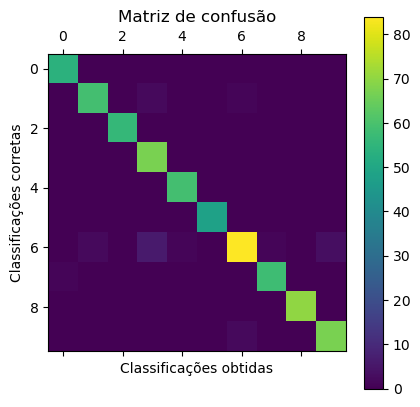

In [69]:
confusion_matrix = confusion_matrix(y_test, predictions)
plt.matshow(confusion_matrix)
plt.title("Matriz de confusão")
plt.colorbar()
plt.ylabel("Classificações corretas")
plt.xlabel("Classificações obtidas")
plt.show()

### Testando novos inputs aleatórios

In [70]:
docs_new = {'docs': [
    'Como posso acessar o site?',
    'Estou com dúvidas sobre o programa de pontos',
    'Fazer cancelamento do contrato',
    'Cobrança indevida',
    'Pontos não estão sendo registrados',
    'Recorrência de cobrança. Cobrança Indevida',
    'CANCELEI ASSINATURA E ESTÃO ME COBRANDO',
    'FATURA NÃO DISPONIBILIZADA NO APLICATIVO',
    '120 dias sem energia injetada',
    'Não houve injeção de energia'
] } 

docs = pd.DataFrame(data=docs_new)

processed = formating(docs['docs'])

predicted = text_clf.predict(processed.tolist())

for doc, category in zip(processed.tolist(), predicted):
    print(doc, ' => ', category)

poss acess sit  =>  acesso ao portal/app
duvid sobr program pont  =>  points
faz cancel contrat  =>  multa/cancelamento
cobranc indev  =>  cobrança indevida
pont nao esta send registr  =>  points
recorrenc cobranc cobranc indev  =>  cobrança indevida
cancel assinat esta cobr  =>  cobrança indevida
fatur nao disponibil aplic  =>  cobrança indevida
numbr dia energ injet  =>  prazo de conexão
nao injeca energ  =>  baixa injeção de energia


### Compactando modelo

In [71]:
import pickle
filename = 'valentini01.pkl'
pickle.dump(text_clf, open(filename, 'wb'))

In [72]:
!ls

 20newsgroups.ipynb
'Chat GPT.ipynb'
'Coleta de dados Reclame Aqui.ipynb'
'Modelo classificador Valentini.ipynb'
'NLP for Text Classification (Jupyter Notebook).ipynb'
'NLP - Portuguese.ipynb'
'Novo Modelo classificador Valentini.ipynb'
 Processamento.ipynb
 template
 Tests.ipynb
 valentini01.pkl
